**Import required libraries**

In [1]:
%pip install plotly.graph_objects

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement plotly.graph_objects (from versions: none)
ERROR: No matching distribution found for plotly.graph_objects


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import openpyxl
import re
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
from wordcloud import WordCloud

**Exploratory Data Analysis**

In [3]:
transaction_data = pd.read_excel("QVI_transaction_data.xlsx")
customer_data = pd.read_csv("QVI_purchase_behaviour.csv")

In [4]:
transaction_data.head(5)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [5]:
customer_data.head(5)

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


***transaction_data***

In [6]:
transaction_data.dtypes

DATE                int64
STORE_NBR           int64
LYLTY_CARD_NBR      int64
TXN_ID              int64
PROD_NBR            int64
PROD_NAME          object
PROD_QTY            int64
TOT_SALES         float64
dtype: object

    So, we need to convert DATE col of this one to DATE format.

In [7]:
#Convert the DATE column to date format
transaction_data["DATE"] = pd.to_datetime(transaction_data["DATE"], origin = '1899-12-30', unit='D')

transaction_data.head(5)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [8]:
transaction_data.groupby('PROD_NAME').size().reset_index(name='Total')

,PROD_NAME,Total
0,Burger Rings 220g,1564
1,CCs Nacho Cheese 175g,1498
2,CCs Original 175g,1514
3,CCs Tasty Cheese 175g,1539
4,Cheetos Chs & Bacon Balls 190g,1479
...,...,...
109,WW Sour Cream &OnionStacked Chips 160g,1483
110,WW Supreme Cheese Corn Chips 200g,1509
111,Woolworths Cheese Rings 190g,1516
112,Woolworths Medium Salsa 300g,1430


    Okay, i see that there are some non-chips products such as 'Woolworths Medium Salsa' and 'Woolworths Mild Salsa'. So we need to check and remove all non-chips before analyzing.

In [9]:
# Examine the words in PROD_NAME 
product_words = transaction_data["PROD_NAME"].unique()
product_words

array(['Natural Chip        Compny SeaSalt175g',
       'CCs Nacho Cheese    175g',
       'Smiths Crinkle Cut  Chips Chicken 170g',
       'Smiths Chip Thinly  S/Cream&Onion 175g',
       'Kettle Tortilla ChpsHny&Jlpno Chili 150g',
       'Old El Paso Salsa   Dip Tomato Mild 300g',
       'Smiths Crinkle Chips Salt & Vinegar 330g',
       'Grain Waves         Sweet Chilli 210g',
       'Doritos Corn Chip Mexican Jalapeno 150g',
       'Grain Waves Sour    Cream&Chives 210G',
       'Kettle Sensations   Siracha Lime 150g',
       'Twisties Cheese     270g', 'WW Crinkle Cut      Chicken 175g',
       'Thins Chips Light&  Tangy 175g', 'CCs Original 175g',
       'Burger Rings 220g', 'NCC Sour Cream &    Garden Chives 175g',
       'Doritos Corn Chip Southern Chicken 150g',
       'Cheezels Cheese Box 125g', 'Smiths Crinkle      Original 330g',
       'Infzns Crn Crnchers Tangy Gcamole 110g',
       'Kettle Sea Salt     And Vinegar 175g',
       'Smiths Chip Thinly  Cut Original 175g', 'K

In [10]:
# Remove special characters and digits
product_words = [re.sub("&", " ", word) for word in product_words]          # Replace '&' with space
product_words = [re.sub(r"\d+[gG]", " ", word) for word in product_words] # Remove weights in grams (e.g., 100g, 500G)

#Split product names into individual words
product_words = [word.split(" ") for word in product_words]

#Flatten the list and remove empty strings
product_words = [word for sublist in product_words for word in sublist if word]
product_words

['Natural',
 'Chip',
 'Compny',
 'SeaSalt',
 'CCs',
 'Nacho',
 'Cheese',
 'Smiths',
 'Crinkle',
 'Cut',
 'Chips',
 'Chicken',
 'Smiths',
 'Chip',
 'Thinly',
 'S/Cream',
 'Onion',
 'Kettle',
 'Tortilla',
 'ChpsHny',
 'Jlpno',
 'Chili',
 'Old',
 'El',
 'Paso',
 'Salsa',
 'Dip',
 'Tomato',
 'Mild',
 'Smiths',
 'Crinkle',
 'Chips',
 'Salt',
 'Vinegar',
 'Grain',
 'Waves',
 'Sweet',
 'Chilli',
 'Doritos',
 'Corn',
 'Chip',
 'Mexican',
 'Jalapeno',
 'Grain',
 'Waves',
 'Sour',
 'Cream',
 'Chives',
 'Kettle',
 'Sensations',
 'Siracha',
 'Lime',
 'Twisties',
 'Cheese',
 'WW',
 'Crinkle',
 'Cut',
 'Chicken',
 'Thins',
 'Chips',
 'Light',
 'Tangy',
 'CCs',
 'Original',
 'Burger',
 'Rings',
 'NCC',
 'Sour',
 'Cream',
 'Garden',
 'Chives',
 'Doritos',
 'Corn',
 'Chip',
 'Southern',
 'Chicken',
 'Cheezels',
 'Cheese',
 'Box',
 'Smiths',
 'Crinkle',
 'Original',
 'Infzns',
 'Crn',
 'Crnchers',
 'Tangy',
 'Gcamole',
 'Kettle',
 'Sea',
 'Salt',
 'And',
 'Vinegar',
 'Smiths',
 'Chip',
 'Thinly',
 'Cut'

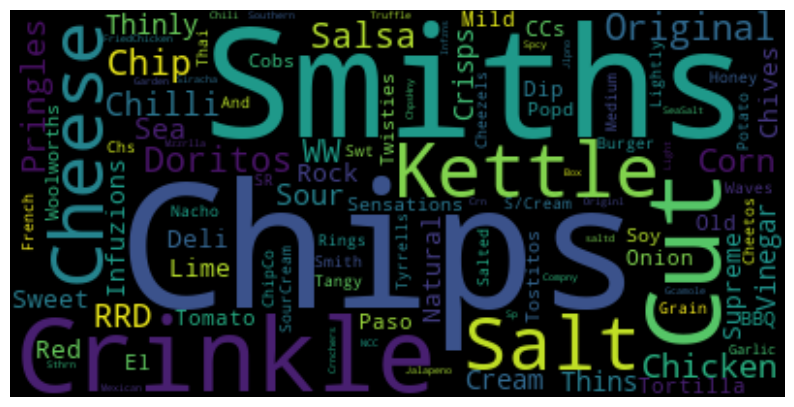

In [11]:
# Display the word cloud
word_cloud = WordCloud(max_words=100).generate_from_frequencies(Counter(product_words))

plt.figure(figsize=(10, 6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [12]:
#Remove SALSA products (I mean non-chip products)
transaction_data['SALSA'] = transaction_data['PROD_NAME'].str.contains("salsa", case=False, na=False)
transaction_data = transaction_data[~transaction_data['SALSA']]  # Filter out rows with SALSA products
transaction_data = transaction_data.drop(columns=['SALSA'])      # Remove SALSA column


In [13]:
transaction_data.isna().sum()

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

       There are no any nulls here. So let's check outliers of 'PRO_QTY', 'TOT_SALES'

Text(0.5, 1.0, 'Boxplot of PROD_QTY')

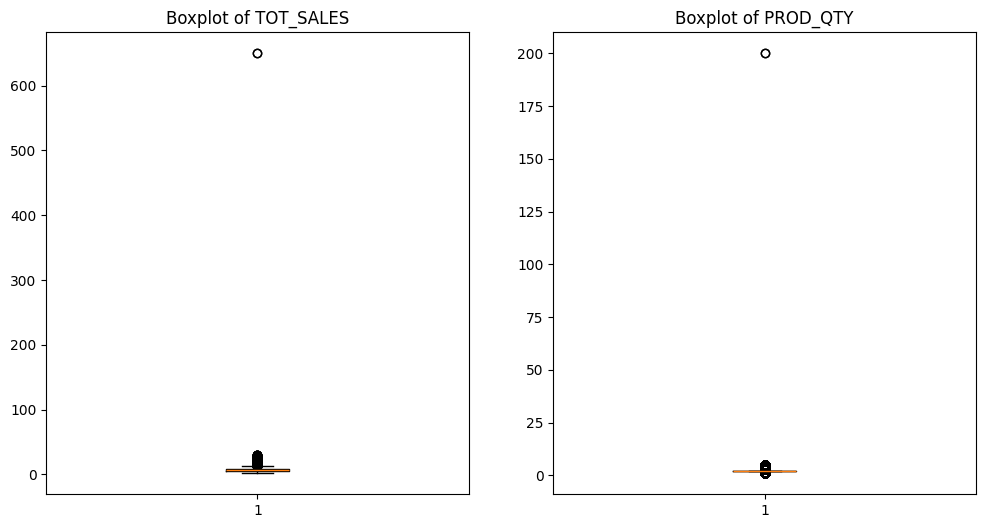

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.boxplot(transaction_data['TOT_SALES'])  
plt.title('Boxplot of TOT_SALES')

plt.subplot(1, 2, 2)
plt.boxplot(transaction_data['PROD_QTY'])  
plt.title('Boxplot of PROD_QTY')


    Okay, we got an outiler.

In [15]:
# Sort this dataset by 'PROD_QTY' in descending order
transaction_data.sort_values(by = 'PROD_QTY', ascending = False)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
135225,2019-05-15,46,46296,42138,81,Pringles Original Crisps 134g,5,18.5
69523,2019-05-15,71,71142,69852,96,WW Original Stacked Chips 160g,5,9.5
69502,2018-08-18,55,55144,49328,44,Thins Chips Light& Tangy 175g,5,16.5
...,...,...,...,...,...,...,...,...
150883,2018-08-14,184,184055,186586,107,Smiths Crinkle Cut French OnionDip 150g,1,2.6
150885,2019-05-17,184,184152,187227,28,Thins Potato Chips Hot & Spicy 175g,1,3.3
29682,2018-12-04,174,174004,174974,114,Kettle Sensations Siracha Lime 150g,1,4.6
150887,2019-05-17,184,184205,187584,13,Red Rock Deli Thai Chilli&Lime 150g,1,2.7


In [16]:
# Sort this dataset by 'TOT_SALES' in descending order
transaction_data.sort_values(by = 'TOT_SALES', ascending = False)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0
69496,2018-08-15,49,49303,45789,14,Smiths Crnkle Chip Orgnl Big Bag 380g,5,29.5
117850,2019-05-19,194,194308,194516,14,Smiths Crnkle Chip Orgnl Big Bag 380g,5,29.5
171815,2018-08-17,24,24095,20797,14,Smiths Crnkle Chip Orgnl Big Bag 380g,5,29.5
...,...,...,...,...,...,...,...,...
234096,2019-04-26,161,161318,161816,55,Snbts Whlgrn Crisps Cheddr&Mstrd 90g,1,1.7
149536,2019-02-06,256,256500,255697,95,Sunbites Whlegrn Crisps Frch/Onin 90g,1,1.7
89677,2018-10-25,124,124115,127849,72,WW Crinkle Cut Original 175g,1,1.7
134767,2018-10-30,268,268247,264664,92,WW Crinkle Cut Chicken 175g,1,1.7


    There are only two transactions where 200 packets of chips are bought in one transaction and both of these transactions were by the same customer. It looks like this customer has only had the two transactions over the year and is not an ordinary retail customer. 

    The customer might be buying chips for commercial purposes instead. We will remove this loyalty card number from further analysis.

In [17]:
# Detect the outliers and save it
transaction_data = transaction_data[transaction_data['PROD_QTY'] != 200]

In [18]:
transaction_data.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246740,246740.000000,2.467400e+05,2.467400e+05,246740.000000,246740.000000,246740.000000
mean,2018-12-30 01:18:58.448569344,135.050361,1.355303e+05,1.351304e+05,56.352213,1.906456,7.316113
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756875e+04,26.000000,2.000000,5.800000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351815e+05,53.000000,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030832e+05,2.026522e+05,87.000000,2.000000,8.800000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,5.000000,29.500000
std,NaN,76.786971,8.071520e+04,7.814760e+04,33.695235,0.342499,2.474897


In [19]:
# Create a dataset with sum of transactions per day
transactions_by_D = pd.DataFrame(transaction_data.groupby('DATE').size().sort_values(ascending=False).reset_index(name = "Total"))
transactions_by_D

,DATE,Total
0,2018-12-24,865
1,2018-12-23,853
2,2018-12-22,840
3,2018-12-19,839
4,2018-12-20,808
...,...,...
359,2019-06-24,612
360,2018-10-18,611
361,2018-11-25,610
362,2018-09-22,609


    There is only 364 rows, meaning only 364 dates which indicates a missing date. 
    
    Lets create a sequence of dates from 1 Jul 2018 to 30 Jun 2019 and use this to create a chart of number of transactions over time to find the missing date.

In [20]:
# Find the missing date
full_dates = pd.DataFrame({
    'DATE': pd.date_range(start='2018-07-01', end='2019-06-30')})

merged_data = pd.merge(full_dates, transactions_by_D, on = 'DATE', how = 'left')
merged_data['Total'] = merged_data['Total'].fillna(0)
merged_data.sort_values(by= 'Total', ascending = True)

,DATE,Total
177,2018-12-25,0.0
347,2019-06-13,607.0
83,2018-09-22,609.0
147,2018-11-25,610.0
109,2018-10-18,611.0
...,...,...
172,2018-12-20,808.0
171,2018-12-19,839.0
174,2018-12-22,840.0
175,2018-12-23,853.0


    We found that the missing date is on 2018-12-25. It is the Christmas day. 

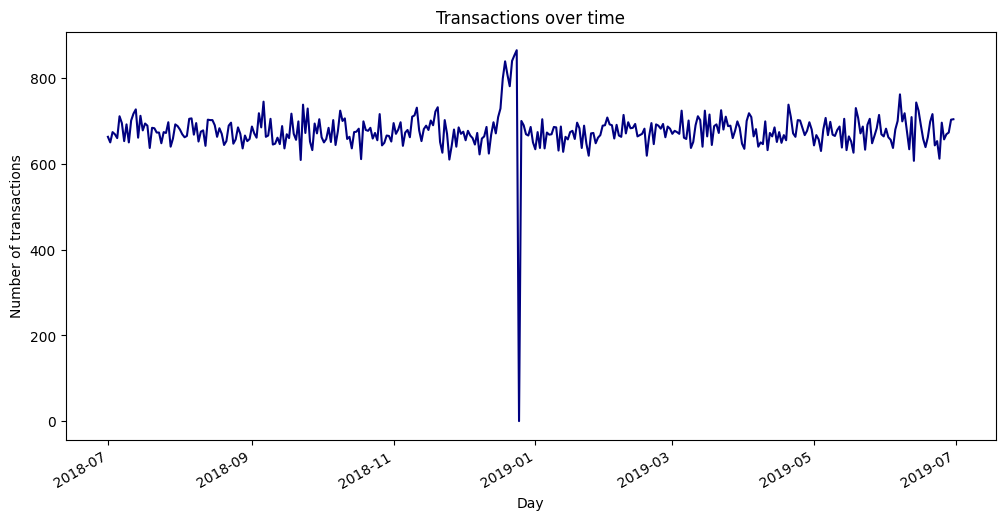

In [21]:
# Display number of transactions per day
plt.figure(figsize=(12, 6))  # Set the figure size

# Create the line plot; NaNs won't be handled automatically here
sns.lineplot(data=merged_data, x='DATE', y='Total', color='navy')

# Add labels and title
plt.xlabel("Day")
plt.ylabel("Number of transactions")
plt.title("Transactions over time")

# Format the date for better readability
plt.gcf().autofmt_xdate() 

# Show the plot 
plt.show() 

    We can see that there is an increase in purchases in December and a break in late December. 

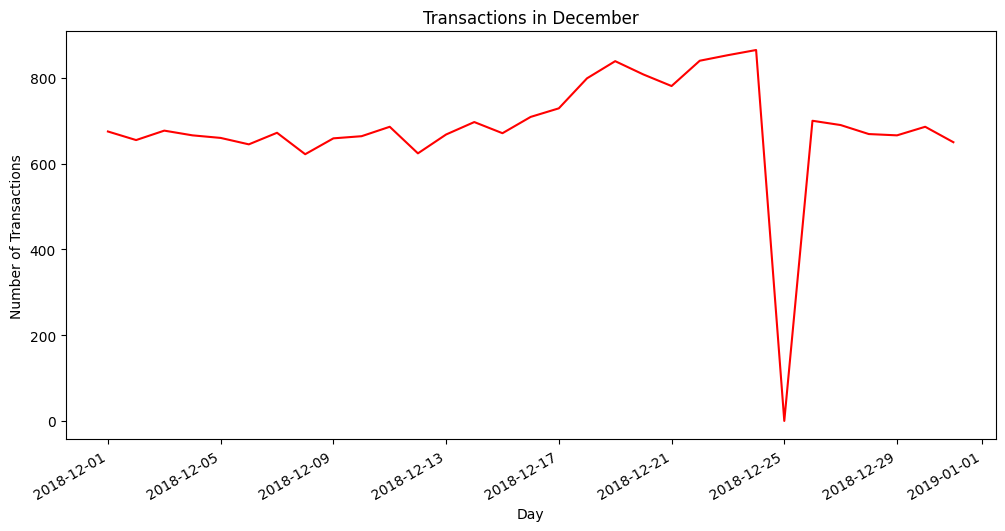

In [22]:
december_data = merged_data[merged_data['DATE'].dt.month == 12]

# Display number of transactions per day
plt.figure(figsize=(12, 6))  # Set the figure size

# Step 2: Create the line plot
sns.lineplot(data=december_data, x='DATE', y='Total', color = 'Red')

# Add labels and title
plt.xlabel("Day")
plt.ylabel("Number of Transactions")
plt.title("Transactions in December")

# Format the date for better readability
plt.gcf().autofmt_xdate() 

# Show the plot 
plt.show()

    We can see that the increase in sales occurs in the lead-up to Christmas and that there are zero sales on
    Christmas day itself. This is due to shops being closed on Christmas day.

    Now that we are satisfied that the data no longer has outliers, we can move on to creating other features
    such as brand of chips or pack size from PROD_NAME. We will start with pack size.


In [23]:
# Extract words that include numbers
transaction_data['PACK_SIZE'] = transaction_data['PROD_NAME'].str.extract('(\d+)').astype(int)

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\PC\AppData\Local\Temp\ipykernel_13372\1610834056.py:2: SyntaxWarning: invalid escape sequence '\d'
  transaction_data['PACK_SIZE'] = transaction_data['PROD_NAME'].str.extract('(\d+)').astype(int)


In [24]:
# Frequency of PACK_SIZE
transactions_by_PACK_SZIE = transaction_data.groupby('PACK_SIZE').size().sort_values(ascending= False).reset_index(name = 'Total')

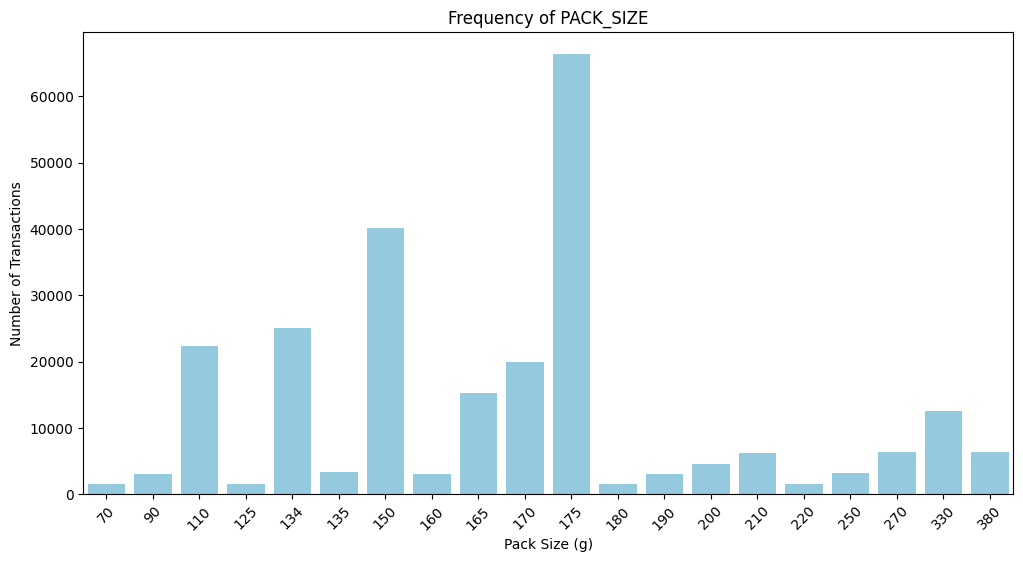

In [46]:
# Display the plot
plt.figure(figsize=(12, 6))
sns.barplot(data=transactions_by_PACK_SZIE, x='PACK_SIZE', y='Total', color='skyblue')
plt.title('Frequency of PACK_SIZE')
plt.xlabel('Pack Size (g)')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)

plt.show()

    Pack sizes created look reasonable and now to create brands, we can use the first word in PROD_NAME to work out the brand names.

In [26]:
# Extract BRAND_NAME
transaction_data['BRAND_NAME'] = transaction_data['PROD_NAME'].str.split().str[0]

In [27]:
# Checking brands
transaction_data.groupby('BRAND_NAME').size().reset_index(name= 'Frequency')

,BRAND_NAME,Frequency
0,Burger,1564
1,CCs,4551
2,Cheetos,2927
3,Cheezels,4603
4,Cobs,9693
5,Dorito,3183
6,Doritos,22041
7,French,1418
8,Grain,6272
9,GrnWves,1468


    Okay, here we got many BRAND_NAMEs that are the same as other. That include: Red = RRD, Sunbites = Snbts, Infuzions = Infzns, Woolworths = WW, Smiths = Smith, Natural = NCC, Doritos = Dorito, Grain = GrnWves

In [28]:
# Clean brand names
transaction_data['BRAND_NAME'] = transaction_data['BRAND_NAME'].replace({
    "Red": "RRD",
    "Snbts": "Sunbites",
    "Infzns": "Infuzions",
    "WW": "Woolworths",
    "Smith": "Smiths",
    "NCC": "Natural",
    "Dorito": "Doritos"
})

In [29]:
# Checking brands
brands_data = transaction_data.groupby('BRAND_NAME').size().sort_values(ascending=False).reset_index(name= 'Frequency')

***customer_data dataset***

In [30]:
customer_data.dtypes

LYLTY_CARD_NBR       int64
LIFESTAGE           object
PREMIUM_CUSTOMER    object
dtype: object

In [31]:
customer_data.describe()

,LYLTY_CARD_NBR
count,7.263700e+04
mean,1.361859e+05
std,8.989293e+04
min,1.000000e+03
25%,6.620200e+04
50%,1.340400e+05
75%,2.033750e+05
max,2.373711e+06


In [32]:
# Examine the values of lifestage
customer_data.groupby('LIFESTAGE').size().sort_values(ascending=False)


LIFESTAGE
RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9780
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
dtype: int64

In [33]:
# Examine the values of premium_customer
customer_data.groupby('PREMIUM_CUSTOMER').size().sort_values(ascending=False)

PREMIUM_CUSTOMER
Mainstream    29245
Budget        24470
Premium       18922
dtype: int64

    As there do not seem to be any issues with the customer data, we can now go ahead and join the transaction and customer data sets together

**Set primary keys for 2 dataset: transaction_data and customer_data and merge this ones**

In [34]:
# Set the index of customer_data to 'LYLTY_CARD_NBR'
customer_data.set_index('LYLTY_CARD_NBR', inplace=True)

# Set the index of transaction_data to 'TXN_ID'
transaction_data.set_index('TXN_ID', inplace=True)

In [35]:
# Merge two dataset before analyzing
df = pd.merge(transaction_data, customer_data, on = 'LYLTY_CARD_NBR')
df.head(5)

,DATE,STORE_NBR,LYLTY_CARD_NBR,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND_NAME,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,66,CCs Nacho Cheese 175g,3,6.3,175,CCs,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smiths,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle,MIDAGE SINGLES/COUPLES,Budget


In [36]:
# Check
df.isnull().sum()

DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
BRAND_NAME          0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

**DATA ANALYZING**

***Proportion of total sales by 'LIFESTAGE' and 'PREMIUM_CUSTOMER'***

In [37]:
# Create total sales by 'LIFESTAGE' and 'PREMIUM_CUSTOMER' dataset
sales_data = df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg(SALES = ('TOT_SALES', 'sum')).reset_index()

# Caculate the proportion
sales_data['PROPORTION'] = (sales_data['SALES']/sales_data['SALES'].sum()*100).round(2)

sales_data.head(10)

,LIFESTAGE,PREMIUM_CUSTOMER,SALES,PROPORTION
0,MIDAGE SINGLES/COUPLES,Budget,33345.70,1.85
1,MIDAGE SINGLES/COUPLES,Mainstream,84734.25,4.69
2,MIDAGE SINGLES/COUPLES,Premium,54443.85,3.02
3,NEW FAMILIES,Budget,20607.45,1.14
4,NEW FAMILIES,Mainstream,15979.70,0.89
5,NEW FAMILIES,Premium,10760.80,0.60
6,OLDER FAMILIES,Budget,156863.75,8.69
7,OLDER FAMILIES,Mainstream,96413.55,5.34
8,OLDER FAMILIES,Premium,75242.60,4.17
9,OLDER SINGLES/COUPLES,Budget,127833.60,7.08


In [38]:
# Total sales by LIFESTAGES
sales_by_lifestage = sales_data.groupby('LIFESTAGE')['SALES'].sum().reset_index()
labels = sales_by_lifestage['LIFESTAGE']
values = sales_by_lifestage['SALES']
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_layout(title_text='Proportion of Total Sales by LIFESTAGE')
fig.show()

From the plot, we can observe that the majority of total sales come from the following groups in order: Older Singles/Couples, Retirees, Older Families, Young Families, and Young Singles/Couples. In contrast, the percentage of sales from Mid-age Singles/Couples accounts for nearly 10%, while New Families contribute less than 3%.

    Okay. To enhance sales, we will concentrate our analysis on the five main groups: Older Singles/Couples, Retirees, Older Families, Young Families, and Young Singles/Couples. By prioritizing these segments, we aim to identify strategies that will effectively boost sales performance.

In [39]:
# Total sales by PREMIUM_CUSTOMER
sales_by_lifestage = sales_data.groupby('PREMIUM_CUSTOMER')['SALES'].sum().reset_index()
labels = sales_by_lifestage['PREMIUM_CUSTOMER']
values = sales_by_lifestage['SALES']
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_layout(title_text='Proportion of Total Sales by PREMIUM_CUSTOMER')
fig.show()


'Mainstream': This group represents the largest customer base, accounting for 38.8% of total sales. Customers in this segment typically have average needs and preferences. They seek affordable products that still maintain a certain level of quality. This indicates that the company should focus on creating value for these customers while maintaining reasonable pricing.

'Budget': Comprising 35% of total sales, this group of customers is primarily focused on cost-saving. They often opt for cheaper products and may not prioritize brand names. This suggests that the company should consider offering budget-friendly options to cater to this price-sensitive demographic, ensuring that quality is still considered to retain customer loyalty.

'Premium': This segment accounts for 26.2% of total sales. Customers here tend to spend more on high-quality products and well-known brands, and they seek top-notch experiences. Although this group is the smallest in terms of revenue share, its contribution is significant. There is a clear opportunity for the company to develop and expand its market for premium products, indicating potential for growth in this segment.

    The majority of sales comes from the Mainstream segment, followed closely by the Budget segment, while the Premium segment, despite its smaller share, remains impactful. The presence of the Premium segment highlights a market opportunity for upscale product development, suggesting that investing in this area could yield significant returns. 

In [40]:
# Proportion of total sales by 'LIFESTAGE' and 'PREMIUM_CUSTOMER'
fig = px.bar(sales_data, x='LIFESTAGE', y='PROPORTION', color='PREMIUM_CUSTOMER', title='Proportion of Total Sales by LIFESTAGE and PREMIUM_CUSTOMER', width=1000, height=600)
fig.update_layout(xaxis_title='LIFESTAGE - PREMIUM_CUSTOMER', yaxis_title='Proportion (%)')
fig.show()



Older Singles/Couples and Retirees are the two groups with the highest consumption rates across different segments. They have significant purchasing power not only in the Budget and Mainstream segments but also in the Premium segment. Although they have a high demand for mid-range and low-cost products, the Premium segment also attracts their attention at a comparable rate. This indicates that older customers, including Older Singles/Couples and Retirees, tend to have diverse consumption patterns and are willing to pay for premium products when they see suitable value. 

    Therefore, marketing and product development strategies aimed at this customer group should not only focus on affordable or mid-range products but also emphasize the Premium segment, where they are willing to invest more in quality and experience.

Older Families show the highest total sales for chips in the Budget segment, accounting for 8.69%. This suggests a strong preference for lower-cost products. To capitalize on this, businesses should focus on offering affordable chips options with targeted promotions that cater to this price-sensitive group.

Young Singles/Couples dominate the Mainstream segment, with 8.18% of chips sales, indicating a preference for mid-range products. Marketing strategies should highlight quality and appeal to their active, modern lifestyle, positioning chips as a premium yet accessible snack choice for this demographic.

New Families report the lowest total sales of chips across all segments, reflecting a limited budget and lower overall consumption.

    In contrast, Older Families, Older Singles/Couples, and Retirees collectively drive higher total sales of chips compared to younger groups, particularly in the Budget and Mainstream segments. Given their diverse needs, marketing strategies should be adaptable, addressing demand across a wide price range, from budget-friendly to premium offerings.

**Proportion of chips product by BRAND NAME**

In [41]:
# Calculate the total sales by BRAND_NAME
brands_data = pd.merge(brands_data, transaction_data.groupby('BRAND_NAME').agg({'TOT_SALES': 'sum'}), on='BRAND_NAME')

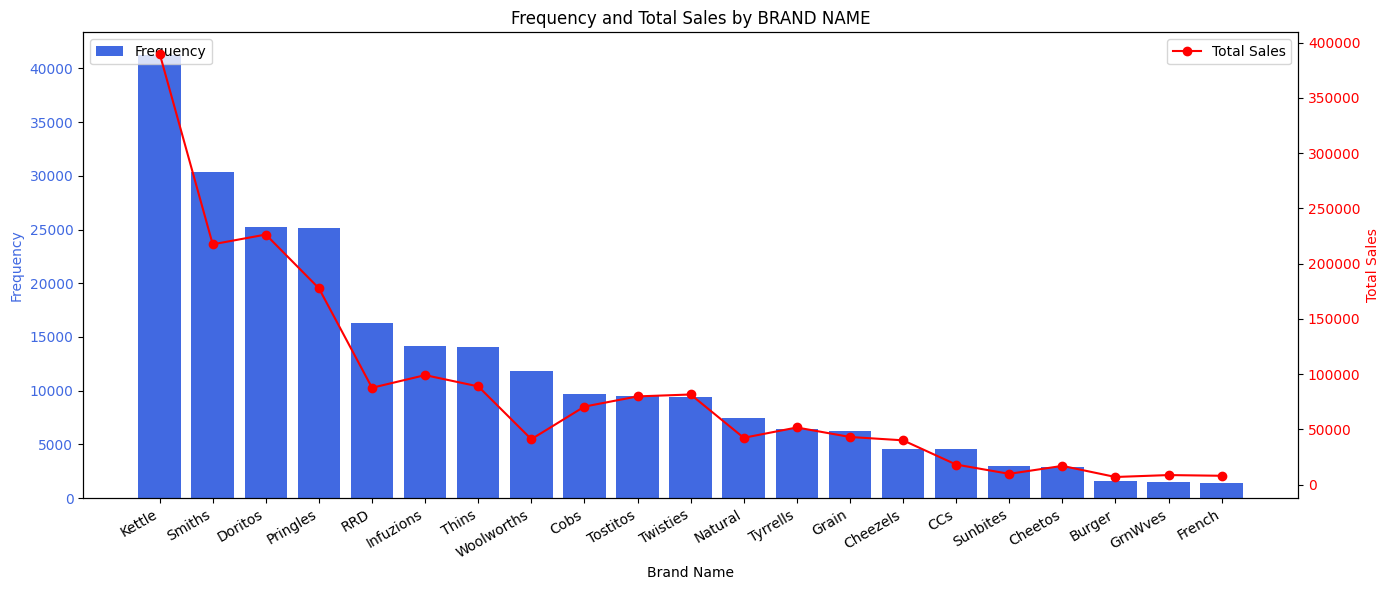

In [42]:
# Display the plot
fig, ax1 = plt.subplots(figsize=(14, 6))  # Unpack figure and axes

# Create a bar plot for Frequency
ax1.bar(brands_data['BRAND_NAME'], brands_data['Frequency'], color='royalblue', label='Frequency')
ax1.set_xlabel('Brand Name')
ax1.set_ylabel('Frequency', color='royalblue')
ax1.tick_params(axis='y', labelcolor='royalblue')
ax1.legend(loc='upper left')

# Create a secondary y-axis for Total Sales
ax2 = ax1.twinx()
ax2.plot(brands_data['BRAND_NAME'], brands_data['TOT_SALES'], zorder=2, color='red', label='Total Sales', marker='o')
ax2.set_ylabel('Total Sales', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

# Set the title
plt.title('Frequency and Total Sales by BRAND NAME')

# Rotate the x-axis labels
plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')

# Adjust the layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


Okay, it can be seen that the frequency of Brand Names is proportional to their Total Sales. The more frequently they appear, the higher their total sales. Most of the sales revenue comes from brands like 'Kettle', 'Smiths', 'Doritos', or 'Pringles'. Although Doritos appears less frequently than Smiths, the sales revenue from Doritos products is higher than that of Smiths products. This could be due to differences in product pricing or packaging sizes.

It can be observed that sales gradually decrease from left to right. This indicates fierce competition in the chip market, where only a few brands dominate.

**Focusing on analyzing customer behaviors**

***Older Singles/Couples***

In [91]:
older_singles_couples = pd.DataFrame(df[df['LIFESTAGE'] == 'OLDER SINGLES/COUPLES'].groupby(['BRAND_NAME', 'PACK_SIZE']).agg({'TOT_SALES': 'sum'})).sort_values(by='TOT_SALES', ascending=False).reset_index().head(30)

# Create a stacked bar chart with BRAND_NAME on the x-axis and TOT_SALES on the y-axis, stacked by PACK_SIZE
fig = px.bar(older_singles_couples, x='BRAND_NAME', y='TOT_SALES', color='PACK_SIZE', barmode='stack', 
             title='Total Sales by Brand and Pack Size')

# Update layout
fig.update_layout(xaxis_title='Brand Name', yaxis_title='Sales ($)', width=1000, height=600)

# Show plot
fig.show()



Here, I have selected the top 30 Brand Names and Package sizes with the highest total sales. Based on the chart, we can see that the "Older Singles/Couples" customer group tends to buy products from the Kettle (pack sizes: 175g and 150g), Pringles - 134g, Doritos - 170g, and Infuzions - 110g. Additionally, other products from the Kettle, Doritos, and Smiths brands also contribute significantly to the brands' revenue.

***Older Families***

In [92]:
older_singles_couples = pd.DataFrame(df[df['LIFESTAGE'] == 'OLDER FAMILIES'].groupby(['BRAND_NAME', 'PACK_SIZE']).agg({'TOT_SALES': 'sum'})).sort_values(by='TOT_SALES', ascending=False).reset_index().head(30)

# Create a stacked bar chart with BRAND_NAME on the x-axis and TOT_SALES on the y-axis, stacked by PACK_SIZE
fig = px.bar(older_singles_couples, x='BRAND_NAME', y='TOT_SALES', color='PACK_SIZE', barmode='stack', 
             title='Total Sales by Brand and Pack Size')

# Update layout
fig.update_layout(xaxis_title='Brand Name', yaxis_title='Sales ($)', width=1000, height=600)

# Show plot
fig.show()

In [ ]:
import plotly.express as px
import numpy as np
df = px.older_singles_couples.sort_values(by='TOT_SALES', ascending=False).head(15)
fig = px.treemap(df, path=[px.Constant("Chips products"), 'BRAND_NAME', 'PACK_SIZE'], values='TOT_SALES',
                  color='lifeExp', 
                  color_continuous_scale='RdBu',
                  color_continuous_midpoint=np.average(df['lifeExp'], weights=df['pop']))
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

TOT_SALES
BRAND_NAME PACK_SIZE           
Burger     220          1271.90
CCs        175          3385.20
Cheetos    165          1377.60
           190          2013.00
Cheezels   125          1190.70
           330          7119.30
Cobs       110         14812.40
Doritos    150         10190.70
           170         22448.80
           330          6976.80
           380          8459.75
French     175          1566.00
Grain      210          9028.80
GrnWves    180          1723.60
Infuzions  70           1382.40
           110         19338.20
Kettle     135          5951.40
           150         36390.60
           175         41520.60
Natural    175          8322.00
Pringles   134         37603.10
RRD        150          8623.80
           165          7767.00
Smiths     150          5850.00
           170          7873.50
           175          8175.00
           330         14312.70
           380          7528.40
Sunbites   90           1888.70
Thins      175         18885.90
Tostitos   175         17248.00
Twisties   250          5516.90
           270         11426.40
Tyrrells   165         10810.80
Woolworths 160          2107.10
           175          1829.20
           190           968.40
           200          3135.00

In [ ]:
import plotly.express as px
import numpy as np
df = px.older_singles_couples.sort_values(by='TOT_SALES', ascending=False).head(15)
fig = px.treemap(df, path=[px.Constant("Chips products"), 'BRAND_NAME', 'PACK_SIZE'], values='TOT_SALES',
                  color='lifeExp', 
                  color_continuous_scale='RdBu',
                  color_continuous_midpoint=np.average(df['lifeExp'], weights=df['pop']))
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

TOT_SALES
BRAND_NAME PACK_SIZE           
Burger     220          1271.90
CCs        175          3385.20
Cheetos    165          1377.60
           190          2013.00
Cheezels   125          1190.70
           330          7119.30
Cobs       110         14812.40
Doritos    150         10190.70
           170         22448.80
           330          6976.80
           380          8459.75
French     175          1566.00
Grain      210          9028.80
GrnWves    180          1723.60
Infuzions  70           1382.40
           110         19338.20
Kettle     135          5951.40
           150         36390.60
           175         41520.60
Natural    175          8322.00
Pringles   134         37603.10
RRD        150          8623.80
           165          7767.00
Smiths     150          5850.00
           170          7873.50
           175          8175.00
           330         14312.70
           380          7528.40
Sunbites   90           1888.70
Thins      175         18885.90
Tostitos   175         17248.00
Twisties   250          5516.90
           270         11426.40
Tyrrells   165         10810.80
Woolworths 160          2107.10
           175          1829.20
           190           968.40
           200          3135.00

***Retirees***

In [93]:
older_singles_couples = pd.DataFrame(df[df['LIFESTAGE'] == 'RETIREES'].groupby(['BRAND_NAME', 'PACK_SIZE']).agg({'TOT_SALES': 'sum'})).sort_values(by='TOT_SALES', ascending=False).reset_index().head(30)

# Create a stacked bar chart with BRAND_NAME on the x-axis and TOT_SALES on the y-axis, stacked by PACK_SIZE
fig = px.bar(older_singles_couples, x='BRAND_NAME', y='TOT_SALES', color='PACK_SIZE', barmode='stack', 
             title='Total Sales by Brand and Pack Size')

# Update layout
fig.update_layout(xaxis_title='Brand Name', yaxis_title='Sales ($)', width=1000, height=600)

# Show plot
fig.show()

***Young Families***

In [95]:
older_singles_couples = pd.DataFrame(df[df['LIFESTAGE'] == 'YOUNG FAMILIES'].groupby(['BRAND_NAME', 'PACK_SIZE']).agg({'TOT_SALES': 'sum'})).sort_values(by='TOT_SALES', ascending=False).reset_index().head(30)

# Create a stacked bar chart with BRAND_NAME on the x-axis and TOT_SALES on the y-axis, stacked by PACK_SIZE
fig = px.bar(older_singles_couples, x='BRAND_NAME', y='TOT_SALES', color='PACK_SIZE', barmode='stack', 
             title='Total Sales by Brand and Pack Size')

# Update layout
fig.update_layout(xaxis_title='Brand Name', yaxis_title='Sales ($)', width=1000, height=600)

# Show plot
fig.show()

***Young Singles/Couples***

In [94]:
older_singles_couples = pd.DataFrame(df[df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES'].groupby(['BRAND_NAME', 'PACK_SIZE']).agg({'TOT_SALES': 'sum'})).sort_values(by='TOT_SALES', ascending=False).reset_index().head(30)

# Create a stacked bar chart with BRAND_NAME on the x-axis and TOT_SALES on the y-axis, stacked by PACK_SIZE
fig = px.bar(older_singles_couples, x='BRAND_NAME', y='TOT_SALES', color='PACK_SIZE', barmode='stack', 
             title='Total Sales by Brand and Pack Size')

# Update layout
fig.update_layout(xaxis_title='Brand Name', yaxis_title='Sales ($)', width=1000, height=600)

# Show plot
fig.show()

***Mid-age Singles/Couples***

In [96]:
older_singles_couples = pd.DataFrame(df[df['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES'].groupby(['BRAND_NAME', 'PACK_SIZE']).agg({'TOT_SALES': 'sum'})).sort_values(by='TOT_SALES', ascending=False).reset_index().head(30)

# Create a stacked bar chart with BRAND_NAME on the x-axis and TOT_SALES on the y-axis, stacked by PACK_SIZE
fig = px.bar(older_singles_couples, x='BRAND_NAME', y='TOT_SALES', color='PACK_SIZE', barmode='stack', 
             title='Total Sales by Brand and Pack Size')

# Update layout
fig.update_layout(xaxis_title='Brand Name', yaxis_title='Sales ($)', width=1000, height=600)

# Show plot
fig.show()

***New Families***

In [97]:
older_singles_couples = pd.DataFrame(df[df['LIFESTAGE'] == 'NEW FAMILIES'].groupby(['BRAND_NAME', 'PACK_SIZE']).agg({'TOT_SALES': 'sum'})).sort_values(by='TOT_SALES', ascending=False).reset_index().head(30)

# Create a stacked bar chart with BRAND_NAME on the x-axis and TOT_SALES on the y-axis, stacked by PACK_SIZE
fig = px.bar(older_singles_couples, x='BRAND_NAME', y='TOT_SALES', color='PACK_SIZE', barmode='stack', 
             title='Total Sales by Brand and Pack Size')

# Update layout
fig.update_layout(xaxis_title='Brand Name', yaxis_title='Sales ($)', width=1000, height=600)

# Show plot
fig.show()


        Overall, the consumption trends across different customer groups are relatively similar. All groups tend to prefer products from Kettle (pack sizes: 175g and 150g), Pringles - 134g, Doritos - 170g, Infuzions - 110g, Thins - 175g, followed by Tostitos, Cobs, and Smiths. As a result, we cannot derive a specific marketing strategy from this general view.

        Therefore, we proceed to analyze based on average number of units per customer by LIFESTAGE and PREMIUM_CUSTOMER

**Analyze based on average number of units per customer by LIFESTAGE and PREMIUM_CUSTOMER**

In [99]:
average_per_units = df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg(
    AVG=('PROD_QTY', lambda x: x.sum() / x.nunique())
).reset_index()

# Create the bar plot using Plotly Express
fig = px.bar(average_per_units, x='LIFESTAGE', y='AVG', color='PREMIUM_CUSTOMER', 
             title='Average Units per Customer by Lifestage and Premium Status', 
             labels={'AVG': 'Avg units per transaction', 'LIFESTAGE': 'Lifestage'},
             barmode='group')

# Update x-axis to rotate the text for better readability
fig.update_layout(xaxis_title="Lifestage", yaxis_title="Avg units per transaction", 
                  xaxis_tickangle=-90)

# Show the plot
fig.show()

Older families and young families in general buy more chips per customer
Let’s also investigate the average price per unit chips bought for each customer segment as this is also a
driver of total sales.

In [102]:
avg_price = df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg(
    AVG=('TOT_SALES', lambda x: x.sum() / df.loc[x.index, 'PROD_QTY'].sum())
).reset_index()

# Create the bar plot using Plotly Express
fig = px.bar(avg_price, x='LIFESTAGE', y='AVG', color='PREMIUM_CUSTOMER', 
             title='Average Price per Unit by Lifestage and Premium Status', 
             labels={'AVG': 'Avg price per unit', 'LIFESTAGE': 'Lifestage'},
             barmode='group')

# Update x-axis to rotate the text for better readability
fig.update_layout(xaxis_title="Lifestage", yaxis_title="Avg price per unit", 
                  xaxis_tickangle=-90)

# Show the plot
fig.show()

Mainstream midage and young singles and couples are more willing to pay more per packet of chips compared to their budget and premium counterparts. This may be due to premium shoppers being more likely to
buy healthy snacks and when they buy chips, this is mainly for entertainment purposes rather than their own
consumption. This is also supported by there being fewer premium midage and young singles and couples
buying chips compared to their mainstream counterparts.
As the difference in average price per unit isn’t large, we can check if this difference is statistically different.

In [103]:
from scipy import stats

# Create a new column for price per unit
df['PRICE'] = df['TOT_SALES'] / df['PROD_QTY']

# Filter data for "YOUNG SINGLES/COUPLES" and "MIDAGE SINGLES/COUPLES" in Mainstream
mainstream_group = df[
    (df['LIFESTAGE'].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"])) &
    (df['PREMIUM_CUSTOMER'] == "Mainstream")
]['PRICE']

# Filter data for "YOUNG SINGLES/COUPLES" and "MIDAGE SINGLES/COUPLES" not in Mainstream
non_mainstream_group = df[
    (df['LIFESTAGE'].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"])) &
    (df['PREMIUM_CUSTOMER'] != "Mainstream")
]['PRICE']

# Perform an independent t-test (one-sided, alternative = "greater")
t_stat, p_value = stats.ttest_ind(mainstream_group, non_mainstream_group, alternative='greater')

# Output the t-statistic and p-value
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 37.83196107667815, P-value: 1.11782280577468e-309


The t-test results in a p-value < 2.2e-16, i.e. the unit price for mainstream, young and mid-age singles and
couples are significantly higher than that of budget or premium, young and midage singles and couples